# Step 1: Set up the model (Importing necessary modules and files)

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'Generative-AI-For-Humanity/Final_Modal-main/'
!git clone https://github.com/MuneebHash/Generative-AI-For-Humanity.git
os.chdir(f'./{CODE_DIR}')

Cloning into 'Generative-AI-For-Humanity'...
remote: Enumerating objects: 71280, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 71280 (delta 6), reused 17 (delta 5), pack-reused 71261 (from 6)
Receiving objects: 100% (71280/71280), 688.95 MiB | 38.79 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (74215/74215), done.
Filtering content: 100% (2/2), 1.35 GiB | 56.17 MiB/s, done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/Generative-AI-For-Humanity/Final_Modal-main/stylegan2-swapper'

/content/Generative-AI-For-Humanity/Final_Modal-main/stylegan2-swapper


In [4]:
import imageio
import requests
import bz2
import shutil
from PIL import Image
import torch
import torchvision.transforms as transforms
import dlib
from pix2pixHD.data.base_dataset import __scale_width
from pix2pixHD.models.networks import define_G
import pix2pixHD.util.util as util
from aligner import align_face

from google.colab import output
from IPython.display import HTML, display
import base64
import imageio

import matplotlib.pyplot as plt
%matplotlib inline

import sys


In [5]:
from IPython.display import HTML, display
import base64

# HTML code for the file upload UI
upload_ui = '''
<!DOCTYPE html>
<html>
<head>
  <title>Image Upload</title>
  <style>
    /* Your CSS styles for the upload UI */
    /* Add styles for the upload box and button */
    .upload-container {
        display: flex;
        flex-direction: column;
        align-items: center;
        justify-content: center;
        height: 200px;
        border: 2px dashed #ccc;
        border-radius: 5px;
        cursor: pointer;
    }
    .upload-container:hover {
        border-color: #aaa;
    }
    #file-input {
        display: none;
    }
    .upload-text {
        font-size: 16px;
        color: #888;
    }
  </style>
</head>
<body>
  <div class="upload-container" onclick="document.getElementById('file-input').click()">
    <input type="file" id="file-input" accept="image/*">
    <p class="upload-text">Click or drag & drop an image here to upload</p>
  </div>

  <script>
    document.getElementById('file-input').addEventListener('change', function() {
      const file = this.files[0];
      if (file) {
        const reader = new FileReader();
        reader.onload = function(event) {
          const imgData = event.target.result;
          // Mock display of the uploaded image
          const imgElement = document.createElement('img');
          imgElement.src = imgData;
          imgElement.style.maxWidth = '25%';
          document.body.appendChild(imgElement);
        };
        reader.readAsDataURL(file);
      }
    });
  </script>
</body>
</html>
'''

In [6]:
from google.colab import output
from IPython.display import HTML
import base64
import imageio

# Varialbe to store uploaded image data
source_image = None

# JavaScript function to send image data to Python
js_code = '''
<script>
  document.getElementById('file-input').addEventListener('change', function() {
    const file = this.files[0];
    if (file) {
      const reader = new FileReader();
      reader.onload = function(event) {
        const imgData = event.target.result;
        google.colab.kernel.invokeFunction('processImageData', [imgData], {});
      };
      reader.readAsDataURL(file);
    }
  });
</script>
'''

# Function to receive image data in Python and save it using imageio
def process_image_data(img_data):
    img_data = img_data.split(",")[1]  # Extract base64 data
    source_image = base64.b64decode(img_data)  # Decode base64 to bytes
    with open('/content/Generative-AI-For-Humanity/Final_Modal-main/Uploaded_Image/input_image.jpg', 'wb') as f:  # Save the image locally
        f.write(source_image)
    print("Image saved")
    return source_image

# Step 2: Input image (Please run this cell before upload input image)

In [7]:
# Display the HTML and JavaScript code in Colab output
display(HTML(upload_ui + js_code))


# Register the Python function as a JavaScript callback
output.register_callback('processImageData', process_image_data)

Image saved


# Step 3: Process the image (The output image is automatically saved)

## Face Align

In [23]:
# Write input image file into imageio.v2
img_url = '/content/Generative-AI-For-Humanity/Final_Modal-main/Uploaded_Image/input_image.jpg'
img_filename = 'input_image.jpg'
imageio.v2.imwrite(img_filename, imageio.v2.imread(img_url))

In [24]:
# bz2 file unpack function
def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path

#file download function
def download(url, file_name):
    with open(file_name, "wb") as file:
        response = requests.get(url)
        file.write(response.content)

In [25]:
# Define the paths
shape_model_drive_path = '/content/Generative-AI-For-Humanity/Final_Modal-main/shape_predictor_68_face_landmarks.dat.bz2'
shape_model_extracted_path = '/content/Generative-AI-For-Humanity/Final_Modal-main/shape_predictor_68_face_landmarks.dat'

# Extract the contents in Google Drive
with open(shape_model_extracted_path, 'wb') as new_file, bz2.BZ2File(shape_model_drive_path, 'rb') as file:
    shutil.copyfileobj(file, new_file)

# Load the model
shape_predictor = dlib.shape_predictor(shape_model_extracted_path)

In [26]:
# Image align with the trained landmark face shape predictor
aligned_img = align_face(img_filename, shape_predictor)[0]

input_image.jpg: Number of faces detected: 2


In [27]:
# Define the source file (in Colab)
aligned_img_path = 'aligned_img.jpg'

aligned_img.save(aligned_img_path)

# Define the destination file in your Google Drive
destination_file = '/content/Generative-AI-For-Humanity/Final_Modal-main/Uploaded_Image/aligned_img.jpg'

# Copy the file to Google Drive
shutil.copy(aligned_img_path, destination_file)
print('Aligned image copied to:', destination_file)

Aligned image copied to: /content/Generative-AI-For-Humanity/Final_Modal-main/Uploaded_Image/aligned_img.jpg


## Check Gender

In [28]:
# Import necessary modules and libraries for classification
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [29]:
# Load trained weight (base model = Resnet18)
save_path = '/content/Generative-AI-For-Humanity/Final_Modal-main/stylegan2-swapper/gender_classification_dataset/face_gender_classification_trained_weights_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Result

In [30]:
from PIL import Image
import torchvision.transforms as transforms

model.eval()

# Load the image using PIL
input_image = Image.open('/content/Generative-AI-For-Humanity/Final_Modal-main/Uploaded_Image/aligned_img.jpg')

# Define the preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

# Apply the preprocessing to your input image
input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

# Move the input tensor to the appropriate device (GPU if available)
input_tensor = input_tensor.to(device)

# Pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_tensor)

# Get the predicted class
_, predicted = torch.max(output, 1)

class_names = ["Female", "Male"]

# Map the predicted class index to the class label
predicted_class = class_names[predicted.item()]
print("Predicted class:", predicted_class)

Predicted class: Male


## Swap Gender

In [31]:
def get_eval_transform(loadSize=512):
    transform_list = []
    transform_list.append(transforms.Lambda(lambda img: __scale_width(img,
                                                                      loadSize,
                                                                      Image.BICUBIC)))
    transform_list += [transforms.ToTensor()]
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

transform = get_eval_transform()

In [32]:
config_G = {
    'input_nc': 3,
    'output_nc': 3,
    'ngf': 64,
    'netG': 'global',
    'n_downsample_global': 4,
    'n_blocks_global': 9,
    'n_local_enhancers': 1,
    'norm': 'instance',
}

if predicted_class == 'Female':
  weights_path = '/content/Generative-AI-For-Humanity/Final_Modal-main/Gender_Weight/to_male_net_G.pth'  # to_male_net_G.pth
else:
  weights_path = '/content/Generative-AI-For-Humanity/Final_Modal-main/Gender_Weight/to_female_net_G.pth'  # to_female_net_G.pth

model = define_G(**config_G)
pretrained_dict = torch.load(weights_path, weights_only=False)
model.load_state_dict(pretrained_dict)
model.cuda();

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

In [33]:
img = transform(aligned_img).unsqueeze(0)

with torch.no_grad():
    out = model(img.cuda())

out = util.tensor2im(out.data[0])

## Find Cosine Similarity

In [34]:
# using torch
def find_cosine_similarity(input_tensor, generated_image):
  # Convert the NumPy array to a PyTorch tensor
  output_tensor = torch.from_numpy(generated_image).permute(2, 0, 1).unsqueeze(0).float()
  # Flatten the tensors to 1D vectors (if needed)
  tensor1_flat = input_tensor.view(1, -1)
  tensor2_flat = output_tensor.view(1, -1)

  # define a method to measure cosine similarity
  cos = torch.nn.CosineSimilarity(dim=1)
  output = cos(tensor1_flat, tensor2_flat)

  # display the output tensor
  return output

def get_similarity_percentage_using_torch(input_tensor, generated_image):
  cos = find_cosine_similarity(input_tensor, generated_image)
  percentage= ((cos.item() + 1) / 2) * 100
  return percentage

## Save Result

In [35]:
# Save image in imageio
imageio.imsave('result.jpg', out)

# Define the source file (in Colab)
source_file = 'result.jpg'  # Replace with your image file name

# Define the destination file in your Google Drive
destination_file = '/content/Generative-AI-For-Humanity/Final_Modal-main/Output_Image/result_image.jpg'

# Copy the file to Google Drive
shutil.copy(source_file, destination_file)
print('Result image copied to:', destination_file)


Result image copied to: /content/Generative-AI-For-Humanity/Final_Modal-main/Output_Image/result_image.jpg


## Check Gender of Output Image

In [36]:
# Import necessary modules and libraries for classification
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
# Load trained weight (base model = Resnet18)
save_path = '/content/Generative-AI-For-Humanity/Final_Modal-main/stylegan2-swapper/gender_classification_dataset/face_gender_classification_trained_weights_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
from PIL import Image
import torchvision.transforms as transforms

model.eval()

# Load the image using PIL
input_image = Image.open('/content/Generative-AI-For-Humanity/Final_Modal-main/Output_Image/result_image.jpg')

# Define the preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

# Apply the preprocessing to your input image
input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

# Move the input tensor to the appropriate device (GPU if available)
input_tensor = input_tensor.to(device)

# Pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_tensor)

# Get the predicted class
_, predicted = torch.max(output, 1)

class_names = ["Female", "Male"]

# Map the predicted class index to the class label
predicted_class = class_names[predicted.item()]
print("Predicted class:", predicted_class)

Predicted class: Female


# Step 4: Display Final Result

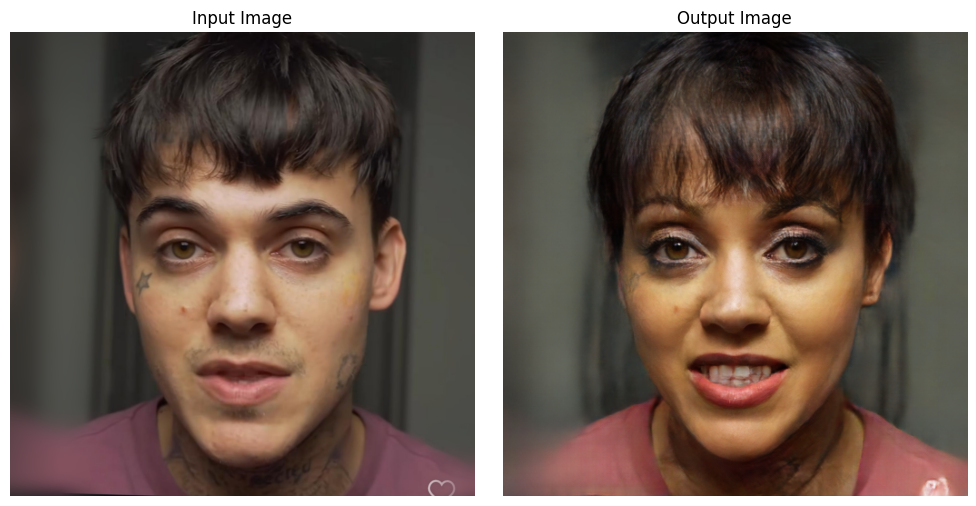

Cosine Similarity Percentage: 27.200770378112793
Prediction Of Output Image: Female


In [38]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(aligned_img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out)
plt.title('Output Image')
plt.axis('off')

plt.tight_layout();

plt.show()
print("Cosine Similarity Percentage: " + str(get_similarity_percentage_using_torch(img, out)))
print("Prediction Of Output Image:", predicted_class)